<a id='table_of_contents'></a>

0. [Import libraries](#imports)
1. [Import data](#import_data)
2. [Data exploration](#data_exploration)
3. [Data cleaning](#data_cleaning)
4. [Data preparation](#data_preparation)
5. [Benchmark model](#benchmark_model)<br>
    5.1. [Train-test split](#train_test_split)<br>
    5.2. [Fit a model to the data](#fit_model)<br>
    5.3. [Model evaluation](#model_evaluation)<br>
    5.4. [Fix problems](#fix_problems)
6. [Feature engineering](#feature_engineering)
7. [Model training](#model_training)<br>
    7.1. [Decision Tree](#decision_tree)<br>
    7.2. [Random Forest](#random_forest) -
      [Overfit](#overfit) - 
      [Underfit](#underfit)<br>
    7.3. [Gradient boosting](#gradient_boosting)<br>
    7.4. [Comparing algorithm performances](#comparing_algorithm_performances)
9. [Tuning](#tuning)<br>
    8.1. [Find best parameters](#find_best_parameters)<br>
    Bonus: [Classification](#classification)

# 0. Import libraries <a id='imports'></a>
[Back to top](#table_of_contents)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# 1. Import data <a id='import_data'></a>
[Back to top](#table_of_contents)

In [3]:
taxi_jan_2019 = pd.read_parquet('../data/raw/yellow_tripdata_2019-01.parquet')
taxi_data = pd.concat([taxi_jan_2019])

In [4]:
print(taxi_data.shape)
taxi_data.head()

(7696617, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN,None
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN,None
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN,None
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN,None
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN,None


# 2. Data exploration <a id='data_exploration'></a>
[Back to top](#table_of_contents)

In [5]:
taxi_data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [6]:
taxi_data = taxi_data[['tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID','PULocationID',
       'DOLocationID', 'payment_type',  'total_amount']]

In [7]:
taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,151,239,1,9.95
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,239,246,1,16.30
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,236,236,1,5.80
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,193,193,2,7.55
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,193,193,2,55.55


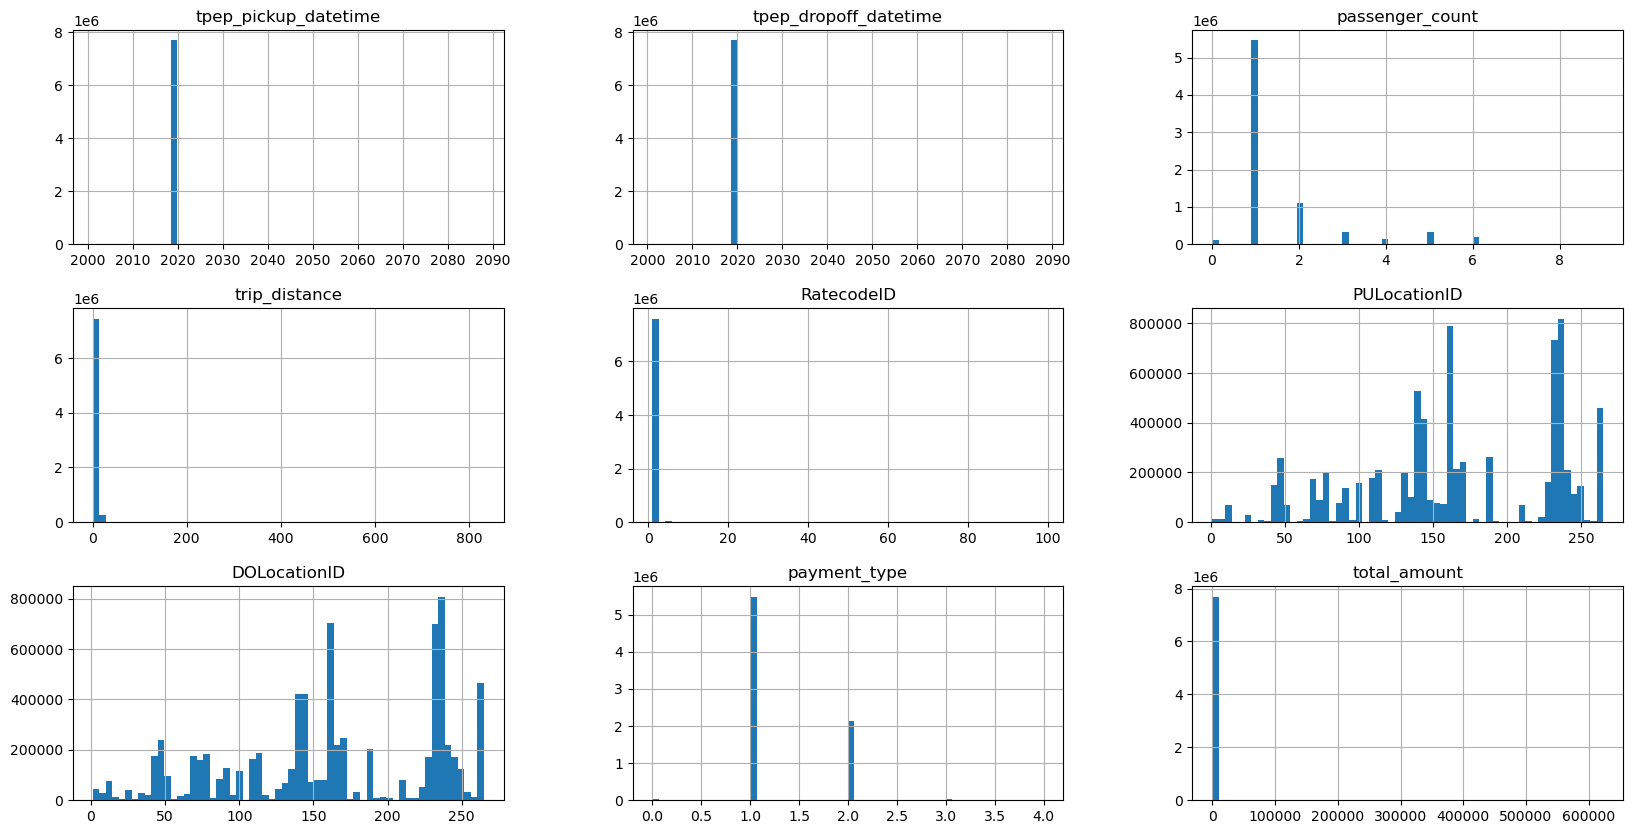

In [ ]:
taxi_data.hist(figsize=(20, 10), bins=60)
plt.show()

In [9]:
taxi_data['RatecodeID'].value_counts()

RatecodeID
1.0     7430288
2.0      166093
5.0       54570
3.0       11801
4.0        4895
99.0        252
6.0          46
Name: count, dtype: int64

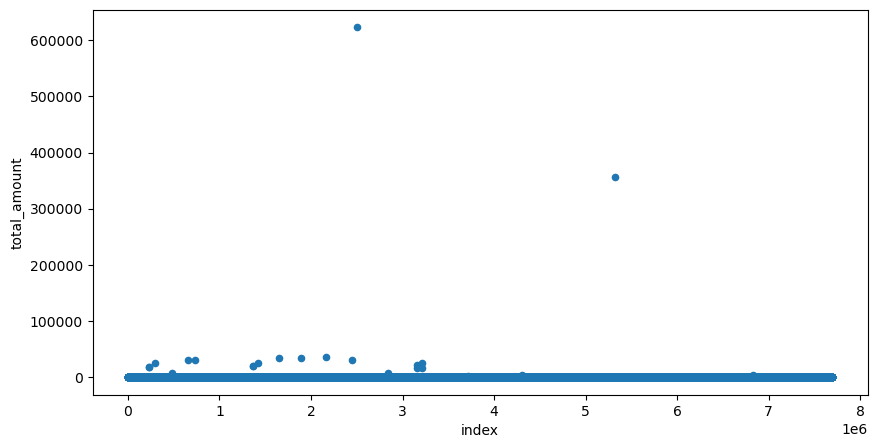

In [ ]:
taxi_data.reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10, 5))
plt.show()

<Axes: xlabel='index', ylabel='total_amount'>

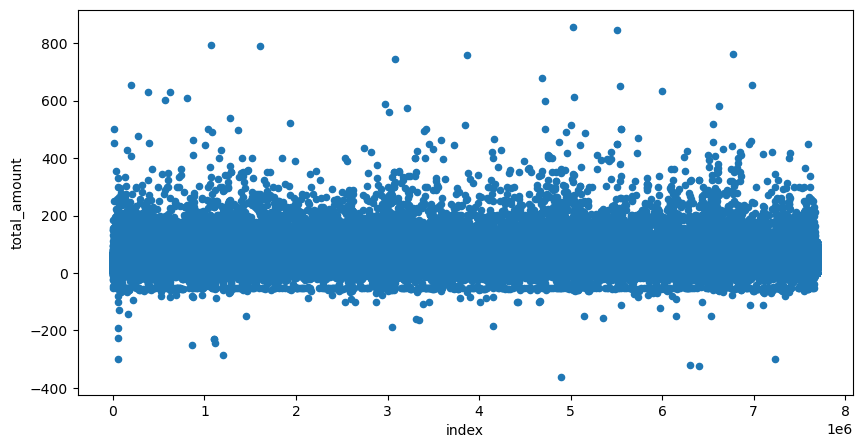

In [11]:
taxi_data[taxi_data['total_amount'] < 1000].reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10, 5))

Two things to deal with: negative values and very high values. Let's first look at negative values.

(7131, 9)


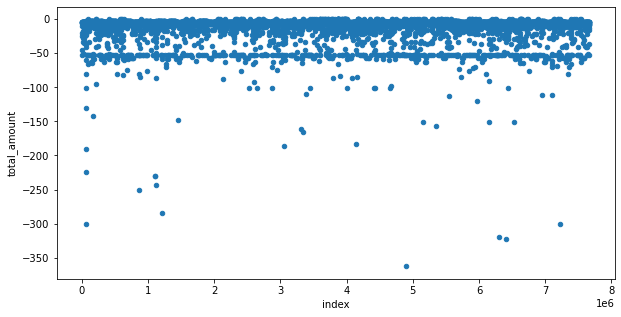

In [52]:
print(taxi_data[taxi_data['total_amount']<0].shape)
taxi_data[taxi_data['total_amount']<0].reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,5))


In [53]:
taxi_data[taxi_data['total_amount']<0].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
663,2019-01-01 00:32:56,2019-01-01 00:33:35,2,0.10,1,148,148,3,-3.8
2402,2019-01-01 00:14:18,2019-01-01 00:40:55,1,4.13,1,170,238,4,-20.3
2541,2019-01-01 00:31:27,2019-01-01 00:42:39,1,1.35,1,162,234,4,-9.8
2544,2019-01-01 00:45:57,2019-01-01 00:46:07,1,0.00,1,234,234,4,-3.8
2547,2019-01-01 00:48:35,2019-01-01 00:49:59,1,0.16,1,234,234,4,-4.3


In [54]:
taxi_data[taxi_data['total_amount']<0]['payment_type'].value_counts()

3    4088
4    2666
2     376
1       1
Name: payment_type, dtype: int64

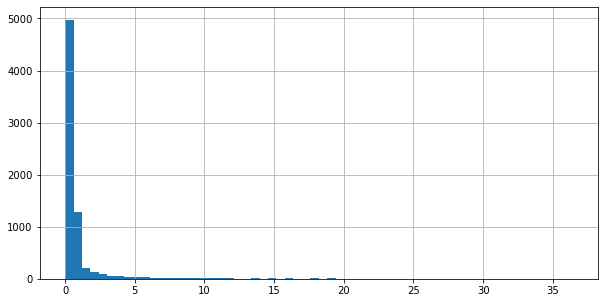

In [55]:
taxi_data[taxi_data['total_amount']<0]['trip_distance'].hist(bins=60, figsize=(10,5))

In [56]:
print(taxi_data[taxi_data['total_amount']==0].shape)
taxi_data[taxi_data['total_amount']==0].head()

(1414, 9)


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
3552,2019-01-01 00:18:46,2019-01-01 00:18:46,1,0.0,5,186,264,2,0.0
9138,2019-01-01 00:41:47,2019-01-01 00:41:47,1,0.0,5,246,264,2,0.0
13256,2019-01-01 00:19:38,2019-01-01 00:20:35,1,0.0,1,193,193,1,0.0
13257,2019-01-01 00:43:34,2019-01-01 00:43:34,1,0.0,1,7,7,2,0.0
13258,2019-01-01 00:02:52,2019-01-01 00:02:52,1,0.0,1,264,7,2,0.0


In [57]:
taxi_data[taxi_data['total_amount']==0]['payment_type'].value_counts()

1    815
2    569
3     29
4      1
Name: payment_type, dtype: int64

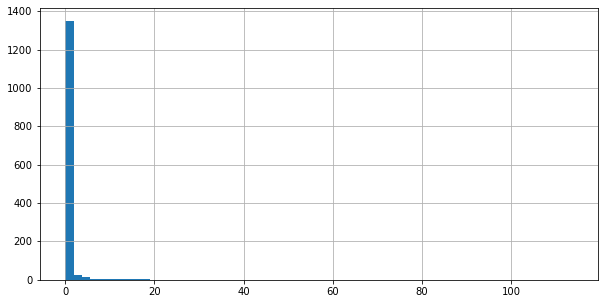

In [58]:
taxi_data[taxi_data['total_amount']==0]['trip_distance'].hist(bins=60, figsize=(10,5))

In [59]:
taxi_data[taxi_data['total_amount']==0]['trip_distance'].value_counts()

0.00    1270
1.00       4
0.01       4
0.02       4
0.03       3
        ... 
0.59       1
0.18       1
5.70       1
0.87       1
1.04       1
Name: trip_distance, Length: 110, dtype: int64

We can safely get rid of the negative values. What about the very high values?

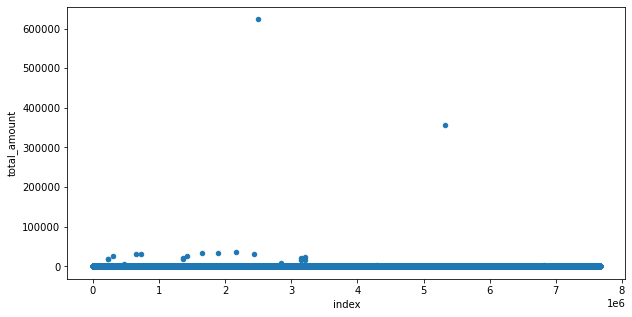

In [60]:
taxi_data.reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,5))

In [61]:
taxi_data[taxi_data['total_amount']>200].shape

(1166, 9)

In [62]:
taxi_data['total_amount'].mean()

15.68222215901336

We can agree to cut from $200 level.

# 3. Data cleaning <a id='data_cleaning'></a>
[Back to top](#table_of_contents)

In [63]:
taxi_data_filtered = taxi_data[(taxi_data['total_amount']>=0)&(taxi_data['total_amount']<200)]

In [64]:
print(taxi_data.shape)
taxi_data_filtered.shape

(7667792, 9)


(7659490, 9)

Checking for missing values.

In [65]:
taxi_data_filtered.isna().sum()

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
total_amount             0
dtype: int64

# 4. Data preparation <a id='data_preparation'></a>
[Back to top](#table_of_contents)

In [66]:
taxi_data_prepared = taxi_data_filtered.copy()

Making sure everything is in the right type

In [67]:
taxi_data_prepared.dtypes

tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
PULocationID               int64
DOLocationID               int64
payment_type               int64
total_amount             float64
dtype: object

In [68]:
taxi_data_prepared.loc[:,'tpep_pickup_datetime'] = pd.to_datetime(taxi_data_prepared.loc[:,'tpep_pickup_datetime'])
taxi_data_prepared.loc[:,'tpep_dropoff_datetime'] = pd.to_datetime(taxi_data_prepared.loc[:,'tpep_dropoff_datetime'])


In [69]:
taxi_data_prepared.loc[:,'RatecodeID']   = taxi_data_prepared['RatecodeID'].astype(str)
taxi_data_prepared.loc[:,'PULocationID'] = taxi_data_prepared['PULocationID'].astype(str)
taxi_data_prepared.loc[:,'DOLocationID'] = taxi_data_prepared['DOLocationID'].astype(str)
taxi_data_prepared.loc[:,'payment_type'] = taxi_data_prepared['payment_type'].astype(str)

In [70]:
taxi_data_prepared.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                       object
PULocationID                     object
DOLocationID                     object
payment_type                     object
total_amount                    float64
dtype: object

Transforming variables into the formats we need them

In [71]:
taxi_data_prepared.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,151,239,1,9.95
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,239,246,1,16.30
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,236,236,1,5.80
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,193,193,2,7.55
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,193,193,2,55.55


In [72]:
taxi_data_prepared['transaction_date'] = pd.to_datetime(taxi_data_prepared['tpep_pickup_datetime'].dt.date)
# -> we make it datetime again because it's very little use when it's just a string (can't compare, sort, etc.)
taxi_data_prepared['transaction_year'] = taxi_data_prepared['tpep_pickup_datetime'].dt.year
taxi_data_prepared['transaction_month'] = taxi_data_prepared['tpep_pickup_datetime'].dt.month
taxi_data_prepared['transaction_day'] =  taxi_data_prepared['tpep_pickup_datetime'].dt.day
taxi_data_prepared['transaction_hour'] = taxi_data_prepared['tpep_pickup_datetime'].dt.hour

In [73]:
taxi_data_prepared.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,transaction_date,transaction_year,transaction_month,transaction_day,transaction_hour
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,151,239,1,9.95,2019-01-01,2019,1,1,0
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,239,246,1,16.30,2019-01-01,2019,1,1,0
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,236,236,1,5.80,2018-12-21,2018,12,21,13
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,193,193,2,7.55,2018-11-28,2018,11,28,15
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,193,193,2,55.55,2018-11-28,2018,11,28,15


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4bc589580>,
      dtype=object)

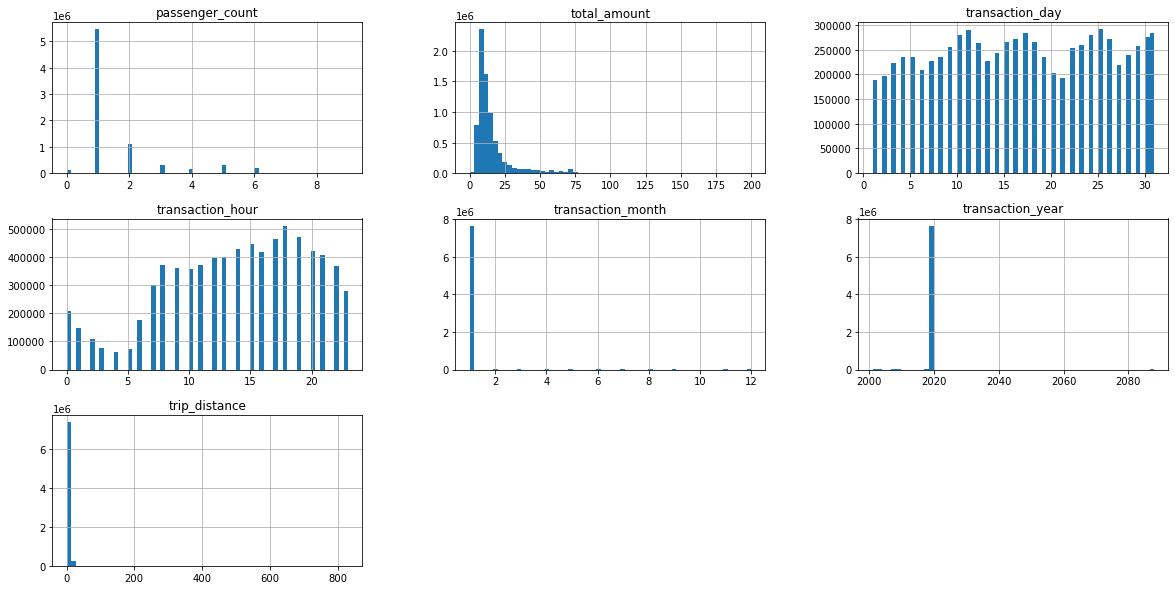

In [74]:
taxi_data_prepared.hist(figsize=(20,10), bins=60)

In [75]:
taxi_data_prepared = taxi_data_prepared[taxi_data_prepared['transaction_year']==2019]
taxi_data_prepared = taxi_data_prepared[taxi_data_prepared['transaction_month']==1]

Noting down categorical and numerical columns

In [76]:
categorical_columns = ['PULocationID','transaction_date','transaction_month','transaction_day','transaction_hour']
numerical_columns = ['trip_distance','total_amount']
all_needed_columns = categorical_columns + numerical_columns


In [77]:
main_taxi_df = taxi_data_prepared[all_needed_columns]
print(main_taxi_df.shape)
main_taxi_df.head()

(7658954, 7)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount
0,151,2019-01-01,1,1,0,1.5,9.95
1,239,2019-01-01,1,1,0,2.6,16.30
7,163,2019-01-01,1,1,0,1.3,9.05
8,229,2019-01-01,1,1,0,3.7,18.50
9,141,2019-01-01,1,1,0,2.1,13.00


Aggregate data points <br>
Now is a good time to think about what we want to predict. Depending on this, we need to transform our data to have a certain format.

In [78]:
taxi_grouped_by_region = main_taxi_df.groupby(categorical_columns).mean().reset_index()
taxi_grouped_by_region['count_of_transactions'] = main_taxi_df.groupby(categorical_columns).count().reset_index()['total_amount']
print(taxi_grouped_by_region.shape)
taxi_grouped_by_region.head()


(102556, 8)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions
0,1,2019-01-01,1,1,2,0.0,21.800,1
1,1,2019-01-01,1,1,5,0.0,87.300,1
2,1,2019-01-01,1,1,6,0.0,80.300,1
3,1,2019-01-01,1,1,8,0.0,128.580,2
4,1,2019-01-01,1,1,10,16.9,43.245,4


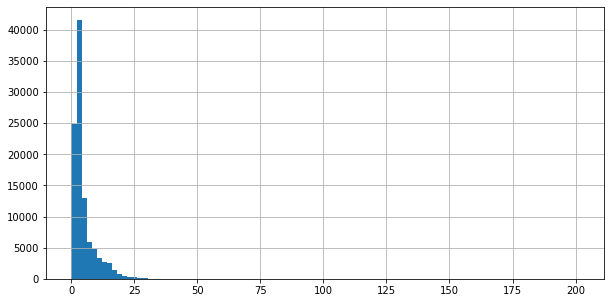

In [79]:
taxi_grouped_by_region['trip_distance'].hist(bins=100, figsize=(10,5))

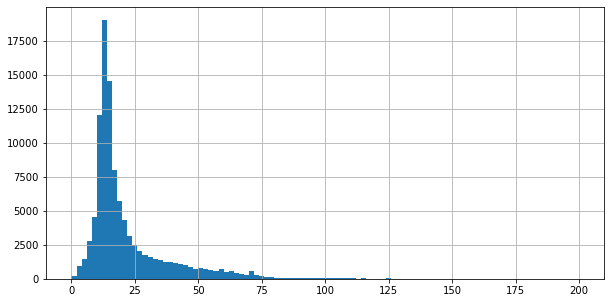

In [80]:
taxi_grouped_by_region['total_amount'].hist(bins=100, figsize=(10,5))

# 5. Benchmark model <a id='benchmark_model'></a>
[Back to top](#table_of_contents)

In [81]:
data_for_benchmark_model = taxi_grouped_by_region.copy()

In [82]:
data_for_benchmark_model

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions
0,1,2019-01-01,1,1,2,0.00,21.800,1
1,1,2019-01-01,1,1,5,0.00,87.300,1
2,1,2019-01-01,1,1,6,0.00,80.300,1
3,1,2019-01-01,1,1,8,0.00,128.580,2
4,1,2019-01-01,1,1,10,16.90,43.245,4
...,...,...,...,...,...,...,...,...
102551,98,2019-01-31,1,31,18,16.66,58.060,1
102552,99,2019-01-18,1,18,18,1.66,9.800,1
102553,99,2019-01-26,1,26,8,0.42,6.000,1
102554,99,2019-01-30,1,30,7,2.87,18.050,1


In [83]:
categorical_features_benchmark = ['PULocationID','transaction_month','transaction_day','transaction_hour']
input_features_benchmark  = categorical_features_benchmark + ['trip_distance']
target_feature_benchmark  = 'total_amount'

## 5.1. Train-test split <a id='train_test_split'></a>

In [84]:
from sklearn.model_selection import train_test_split

X_bench = data_for_benchmark_model[input_features_benchmark]
y_bench = data_for_benchmark_model[target_feature_benchmark]

# one-hot encode
X_bench = pd.get_dummies(X_bench)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bench, y_bench, test_size=0.33, random_state=42)

## 5.2. Fit a model to the data <a id='fit_model'></a>

In [85]:
from sklearn.tree import DecisionTreeRegressor 

tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train_b, y_train_b)


DecisionTreeRegressor(max_depth=10)

## 5.3. Model evaluation <a id='model_evaluation'></a>

In [86]:
model_at_hand = tree

y_pred_b = model_at_hand.predict(X_test_b)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test_b, y_pred_b))
print('mean_squared_error', mean_squared_error(y_test_b, y_pred_b))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test_b, y_pred_b)))
print('r2', r2_score(y_test_b, y_pred_b))

mean_absolute_error 3.4313471447309563
mean_squared_error 64.2961971730041
root_mean_squared_error 8.018490953602436
r2 0.7705552174199464


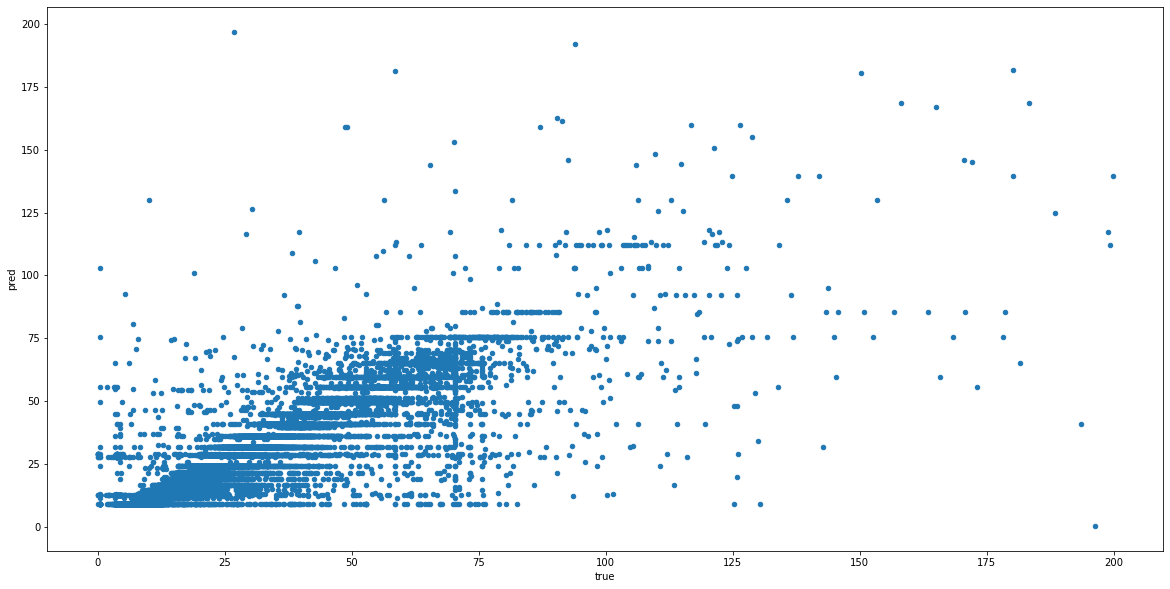

In [87]:
data = {'true': y_test_b, 'pred': y_pred_b}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')

Could this be too good to be true?

## 5.4. Fix problems <a id='fix_problems'></a>

In [88]:
categorical_features_benchmark = ['PULocationID','transaction_month','transaction_day','transaction_hour']
input_features_benchmark  = categorical_features_benchmark
target_feature_benchmark  = 'total_amount'

# Train and test split
from sklearn.model_selection import train_test_split

X_bench = data_for_benchmark_model[input_features_benchmark]
y_bench = data_for_benchmark_model[target_feature_benchmark]

# one-hot encode
X_bench = pd.get_dummies(X_bench)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bench, y_bench, test_size=0.33, random_state=42)

# Fit a model
from sklearn.tree import DecisionTreeRegressor 

tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train_b, y_train_b)

# Evaluate model
model_at_hand = tree

y_pred_b = model_at_hand.predict(X_test_b)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test_b, y_pred_b))
print('mean_squared_error', mean_squared_error(y_test_b, y_pred_b))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test_b, y_pred_b)))
print('r2', r2_score(y_test_b, y_pred_b))


mean_absolute_error 9.776803074043205
mean_squared_error 217.18626934573558
root_mean_squared_error 14.737240900037415
r2 0.22495795178492728


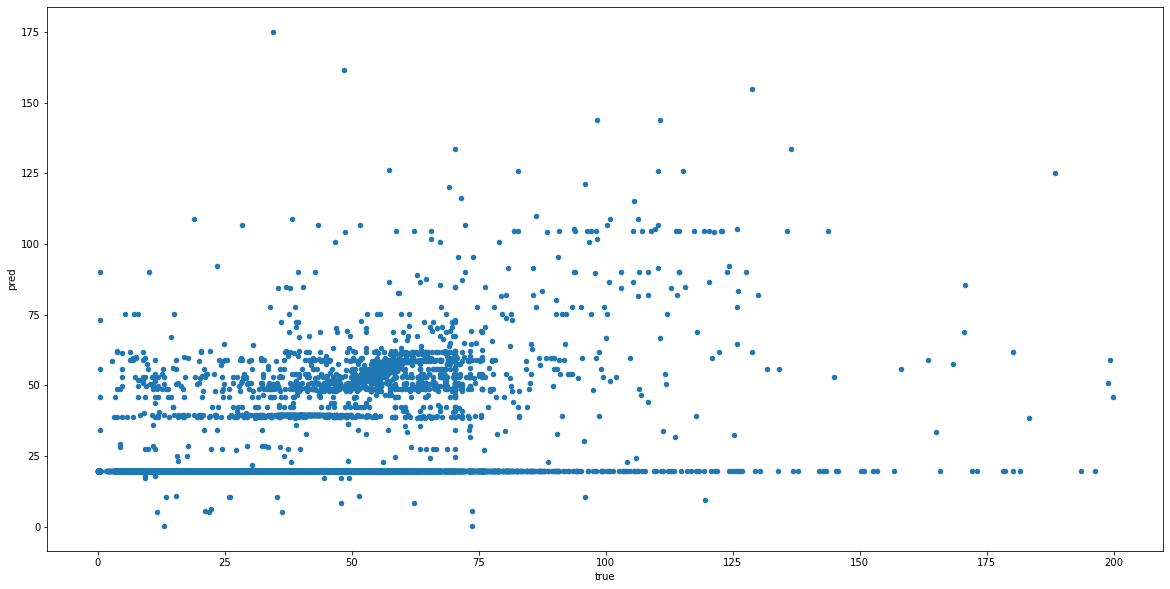

In [89]:
data = {'true': y_test_b, 'pred': y_pred_b}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')

# 6. Feature engineering <a id='feature_engineering'></a>
[Back to top](#table_of_contents)

In [90]:
taxi_grouped_by_region.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions
0,1,2019-01-01,1,1,2,0.0,21.800,1
1,1,2019-01-01,1,1,5,0.0,87.300,1
2,1,2019-01-01,1,1,6,0.0,80.300,1
3,1,2019-01-01,1,1,8,0.0,128.580,2
4,1,2019-01-01,1,1,10,16.9,43.245,4


In [91]:
data_with_new_features = taxi_grouped_by_region.copy()

**Date-related features**

In [92]:
data_with_new_features['transaction_week_day'] = data_with_new_features['transaction_date'].dt.weekday
data_with_new_features['weekend'] = data_with_new_features['transaction_week_day'].apply(lambda x: True if x == 5 or x == 6 else False)


In [93]:
from pandas.tseries.holiday import USFederalHolidayCalendar

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2018',
                        end='2020').date
data_with_new_features['is_holiday'] = data_with_new_features['transaction_date'].isin(holidays)

In [94]:
data_with_new_features.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday
0,1,2019-01-01,1,1,2,0.0,21.800,1,1,False,True
1,1,2019-01-01,1,1,5,0.0,87.300,1,1,False,True
2,1,2019-01-01,1,1,6,0.0,80.300,1,1,False,True
3,1,2019-01-01,1,1,8,0.0,128.580,2,1,False,True
4,1,2019-01-01,1,1,10,16.9,43.245,4,1,False,True


**Borough information**

In [95]:
zone_lookup = pd.read_csv('data/taxi_zone_lookup.csv')
zone_lookup = zone_lookup[['LocationID','Borough']]
zone_lookup['LocationID'] = zone_lookup['LocationID'].astype(str)
zone_lookup.head()

,LocationID,Borough
0,1,EWR
1,2,Queens
2,3,Bronx
3,4,Manhattan
4,5,Staten Island


In [96]:
data_with_new_features = data_with_new_features.merge(zone_lookup, left_on='PULocationID', right_on='LocationID', how='left')
data_with_new_features.drop('LocationID', axis=1, inplace=True)
data_with_new_features.head()


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,Borough
0,1,2019-01-01,1,1,2,0.0,21.800,1,1,False,True,EWR
1,1,2019-01-01,1,1,5,0.0,87.300,1,1,False,True,EWR
2,1,2019-01-01,1,1,6,0.0,80.300,1,1,False,True,EWR
3,1,2019-01-01,1,1,8,0.0,128.580,2,1,False,True,EWR
4,1,2019-01-01,1,1,10,16.9,43.245,4,1,False,True,EWR


In [97]:
data_with_new_features['Borough'].value_counts()

Manhattan        45309
Brooklyn         23633
Queens           22002
Bronx             9586
Unknown           1453
Staten Island      302
EWR                271
Name: Borough, dtype: int64

**Weather related features**

In [98]:
nyc_weather = pd.read_csv('data/nyc_weather.csv')
nyc_weather.head()


,date and time,temperature,humidity,wind speed,cloud cover,amount of precipitation
0,31.12.2019 22:00,6.1,65,6,100%.,0.3
1,31.12.2019 19:00,6.7,71,5,70 – 80%.,NaN
2,31.12.2019 16:00,7.2,66,5,50%.,NaN
3,31.12.2019 13:00,6.1,76,3,100%.,Trace of precipitation
4,31.12.2019 10:00,4.4,83,2,100%.,Trace of precipitation


In [99]:
nyc_weather.shape

(2936, 6)

There are some missing values and there are percentage values that we cannot work easily with. Let's look at them more closely.

In [100]:
nyc_weather.dtypes

date and time               object
temperature                float64
humidity                     int64
wind speed                   int64
cloud cover                 object
amount of precipitation     object
dtype: object

In [101]:
nyc_weather['cloud cover'].value_counts()

70 – 80%.                                                     973
100%.                                                         896
20–30%.                                                       479
50%.                                                          413
no clouds                                                     168
Sky obscured by fog and/or other meteorological phenomena.      3
Name: cloud cover, dtype: int64

In [102]:
nyc_weather['amount of precipitation'].value_counts()

Trace of precipitation    266
0.3                        61
2.0                        49
1.0                        45
0.5                        42
0.8                        42
4.0                        33
5.0                        24
3.0                        23
6.0                        19
7.0                        13
8.0                        13
9.0                        11
10.0                       10
12.0                        7
13.0                        7
15.0                        6
11.0                        5
16.0                        3
14.0                        2
29.0                        2
22.0                        2
18.0                        1
24.0                        1
25.0                        1
20.0                        1
21.0                        1
68.0                        1
30.0                        1
34.0                        1
63.0                        1
17.0                        1
35.0                        1
Name: amou

In [103]:
nyc_weather.isna().sum()

date and time                 0
temperature                   0
humidity                      0
wind speed                    0
cloud cover                   4
amount of precipitation    2240
dtype: int64

Trace of precipitation can be thought of as 0.1<br>
And the missing values 0

In [104]:
nyc_weather['amount of precipitation'] = nyc_weather['amount of precipitation'].replace('Trace of precipitation', 0.1)
nyc_weather['amount of precipitation'] = nyc_weather['amount of precipitation'].astype(float)
# option 1
# nyc_weather['amount of precipitation'].fillna(0, inplace=True)
# option 2
#nyc_weather['amount of precipitation'].fillna(method='ffill', inplace=True)
# option 3
nyc_weather['amount of precipitation'].interpolate(inplace=True)

In [105]:
nyc_weather['cloud cover'] = nyc_weather['cloud cover'].replace('70 – 80%.', 0.7)
nyc_weather['cloud cover'] = nyc_weather['cloud cover'].replace('100%.', 1)
nyc_weather['cloud cover'] = nyc_weather['cloud cover'].replace('20–30%.', 0.3)
nyc_weather['cloud cover'] = nyc_weather['cloud cover'].replace('50%.', 0.5)
nyc_weather['cloud cover'] = nyc_weather['cloud cover'].replace('no clouds', 0)
nyc_weather['cloud cover'] = nyc_weather['cloud cover'].replace('Sky obscured by fog and/or other meteorological phenomena.', 1)
nyc_weather['cloud cover'] = nyc_weather['cloud cover'].astype(float)
nyc_weather['cloud cover'].interpolate(inplace=True)

In [106]:
nyc_weather.dtypes

date and time               object
temperature                float64
humidity                     int64
wind speed                   int64
cloud cover                float64
amount of precipitation    float64
dtype: object

In [107]:
nyc_weather.loc[:,'date and time'] = pd.to_datetime(nyc_weather.loc[:,'date and time'])
nyc_weather['hour'] = nyc_weather['date and time'].dt.hour
nyc_weather['month'] = nyc_weather['date and time'].dt.month
nyc_weather['day'] = nyc_weather['date and time'].dt.day

In [108]:
nyc_weather.head()

,date and time,temperature,humidity,wind speed,cloud cover,amount of precipitation,hour,month,day
0,2019-12-31 22:00:00,6.1,65,6,1.0,0.300000,22,12,31
1,2019-12-31 19:00:00,6.7,71,5,0.7,0.233333,19,12,31
2,2019-12-31 16:00:00,7.2,66,5,0.5,0.166667,16,12,31
3,2019-12-31 13:00:00,6.1,76,3,1.0,0.100000,13,12,31
4,2019-12-31 10:00:00,4.4,83,2,1.0,0.100000,10,12,31


In [109]:
data_with_new_features.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,Borough
0,1,2019-01-01,1,1,2,0.0,21.800,1,1,False,True,EWR
1,1,2019-01-01,1,1,5,0.0,87.300,1,1,False,True,EWR
2,1,2019-01-01,1,1,6,0.0,80.300,1,1,False,True,EWR
3,1,2019-01-01,1,1,8,0.0,128.580,2,1,False,True,EWR
4,1,2019-01-01,1,1,10,16.9,43.245,4,1,False,True,EWR


In [110]:
nyc_taxi_with_weather = data_with_new_features.merge(nyc_weather, left_on = ['transaction_month','transaction_day','transaction_hour'], right_on = ['month','day','hour'], how='left')

print(nyc_taxi_with_weather.shape)
nyc_taxi_with_weather.head()


(102556, 21)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,...,Borough,date and time,temperature,humidity,wind speed,cloud cover,amount of precipitation,hour,month,day
0,1,2019-01-01,1,1,2,0.0,21.800,1,1,False,...,EWR,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2019-01-01,1,1,5,0.0,87.300,1,1,False,...,EWR,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2019-01-01,1,1,6,0.0,80.300,1,1,False,...,EWR,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2019-01-01,1,1,8,0.0,128.580,2,1,False,...,EWR,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2019-01-01,1,1,10,16.9,43.245,4,1,False,...,EWR,2019-01-01 10:00:00,15.6,62.0,11.0,0.7,0.473333,10.0,1.0,1.0


In [111]:
nyc_taxi_with_weather = nyc_taxi_with_weather.drop(['date and time','hour','month','day'], axis=1)


In [112]:
nyc_taxi_with_weather.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,Borough,temperature,humidity,wind speed,cloud cover,amount of precipitation
0,1,2019-01-01,1,1,2,0.0,21.800,1,1,False,True,EWR,NaN,NaN,NaN,NaN,NaN
1,1,2019-01-01,1,1,5,0.0,87.300,1,1,False,True,EWR,NaN,NaN,NaN,NaN,NaN
2,1,2019-01-01,1,1,6,0.0,80.300,1,1,False,True,EWR,NaN,NaN,NaN,NaN,NaN
3,1,2019-01-01,1,1,8,0.0,128.580,2,1,False,True,EWR,NaN,NaN,NaN,NaN,NaN
4,1,2019-01-01,1,1,10,16.9,43.245,4,1,False,True,EWR,15.6,62.0,11.0,0.7,0.473333


In [113]:
nyc_taxi_with_weather.isna().sum()

PULocationID                   0
transaction_date               0
transaction_month              0
transaction_day                0
transaction_hour               0
trip_distance                  0
total_amount                   0
count_of_transactions          0
transaction_week_day           0
weekend                        0
is_holiday                     0
Borough                        0
temperature                68371
humidity                   68371
wind speed                 68371
cloud cover                68371
amount of precipitation    68371
dtype: int64

In [114]:
nyc_taxi_with_weather = nyc_taxi_with_weather.sort_values(['transaction_date','transaction_hour']).reset_index().drop('index',axis=1)

In [115]:
nyc_taxi_with_weather = nyc_taxi_with_weather.interpolate()
nyc_taxi_with_weather = nyc_taxi_with_weather.fillna(method='bfill')
nyc_taxi_with_weather.isna().sum()

PULocationID               0
transaction_date           0
transaction_month          0
transaction_day            0
transaction_hour           0
trip_distance              0
total_amount               0
count_of_transactions      0
transaction_week_day       0
weekend                    0
is_holiday                 0
Borough                    0
temperature                0
humidity                   0
wind speed                 0
cloud cover                0
amount of precipitation    0
dtype: int64

In [714]:
nyc_taxi_with_weather.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,Borough,temperature,humidity,wind speed,cloud cover,amount of precipitation
0,10,2019-01-01,1,1,0,3.020000,14.300000,2,1,False,True,Queens,8.3,97.0,0.0,1.0,29.0
1,100,2019-01-01,1,1,0,2.801852,18.130000,54,1,False,True,Manhattan,8.3,97.0,0.0,1.0,29.0
2,106,2019-01-01,1,1,0,2.593333,15.373333,3,1,False,True,Brooklyn,8.3,97.0,0.0,1.0,29.0
3,107,2019-01-01,1,1,0,2.437458,14.897458,421,1,False,True,Manhattan,8.3,97.0,0.0,1.0,29.0
4,11,2019-01-01,1,1,0,1.795000,9.300000,2,1,False,True,Brooklyn,8.3,97.0,0.0,1.0,29.0


# 7. Model training <a id='model_training'></a>
[Back to top](#table_of_contents)

In [117]:
data_for_model = nyc_taxi_with_weather.copy()

In [118]:
categorical_features = ['PULocationID', 'transaction_month', 'transaction_day',
       'transaction_hour', 'transaction_week_day', 'weekend', 'is_holiday', 'Borough']
input_features = categorical_features + ['temperature', 'humidity', 'wind speed', 'cloud cover',
       'amount of precipitation']
target_feature = 'total_amount'

### train-test split

In [119]:
from sklearn.model_selection import train_test_split

X = data_for_model[input_features]
y = data_for_model[target_feature]

# one-hot encode
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 7.1. Decision tree <a id='decision_tree'></a>

In [727]:
from sklearn.tree import DecisionTreeRegressor 

decision_tree = DecisionTreeRegressor(max_depth=10)
decision_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10)

In [728]:
model_at_hand = decision_tree

y_pred = model_at_hand.predict(X_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test, y_pred))
print('mean_squared_error', mean_squared_error(y_test, y_pred))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test, y_pred)))
print('r2', r2_score(y_test, y_pred))

mean_absolute_error 8.543263133212006
mean_squared_error 197.65100154101845
root_mean_squared_error 14.058840689794392
r2 0.3032678564604542


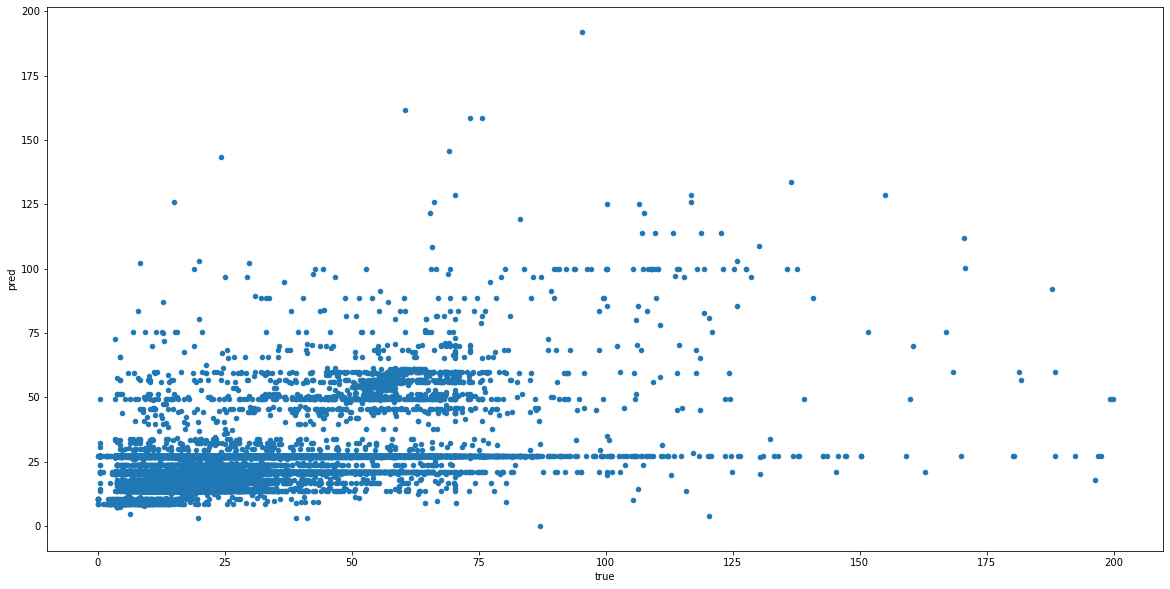

In [721]:
data = {'true': y_test, 'pred': y_pred}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')

### Overfit <a id='overfit'></a>

The model fits the training data's pattern so much that it loses the ability to generalise.

In [724]:
X_train_overfit = X_train
y_train_overfit = y_train

X_test_overfit = X_test
y_test_overfit = y_test

In [725]:
rmse_scores = {'max_depth':[] ,'rmse_train':[], 'rmse_test':[]}

for md in [2, 5, 8, 10, 15, 20, 30, 50, 70, 100, 150]:
    print(md)
    decision_tree_overfit = DecisionTreeRegressor(max_depth=md)
    decision_tree_overfit.fit(X_train_overfit, y_train_overfit)
    
    model_at_hand_overfit = decision_tree_overfit
    
    y_pred_train = model_at_hand_overfit.predict(X_train_overfit)
    rmse_train = sqrt(mean_squared_error(y_train_overfit, y_pred_train))
    
    y_pred_test = model_at_hand_overfit.predict(X_test_overfit)
    rmse_test = sqrt(mean_squared_error(y_test_overfit, y_pred_test))
    
    rmse_scores['max_depth'].append(md)
    rmse_scores['rmse_train'].append(rmse_train)
    rmse_scores['rmse_test'].append(rmse_test)

2
5
8
10
15
20
30
50
70
100
150


In [731]:
pd.DataFrame.from_dict(rmse_scores)

,max_depth,rmse_train,rmse_test
0,2,1.495163e+01,15.174393
1,5,1.412253e+01,14.497210
2,8,1.352369e+01,14.112117
3,10,1.313962e+01,14.015107
4,15,1.204887e+01,14.318298
5,20,1.109997e+01,14.506965
6,30,9.498728e+00,15.044384
7,50,5.425101e+00,16.576495
8,70,1.124528e+00,17.336644
9,100,7.017987e-17,17.479575


Text(0, 0.5, 'root mean squared error')

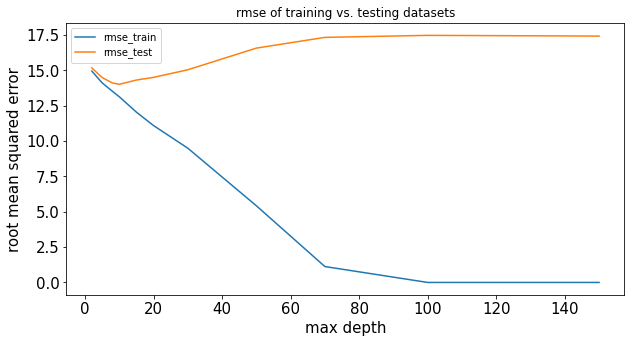

In [726]:
ax = pd.DataFrame.from_dict(rmse_scores).plot(figsize=(10,5),title="rmse of training vs. testing datasets", fontsize=15, x='max_depth')
ax.set_xlabel("max depth", fontsize=15)
ax.set_ylabel("root mean squared error", fontsize=15)

### Underfit <a id='underfit'></a>

Underfit is when the model cannot capture the data's pattern at all

In [732]:
X_train_underfit = X_train
y_train_underfit = y_train

X_test_underfit = X_test
y_test_underfit = y_test

In [733]:
decision_tree_underfit = DecisionTreeRegressor(max_depth=1)
decision_tree_underfit.fit(X_train_underfit, y_train_underfit)

# Training performance

model_at_hand_underfit = decision_tree_underfit

y_pred_underfit = model_at_hand_underfit.predict(X_train_underfit)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_train_underfit, y_pred_underfit))
print('mean_squared_error', mean_squared_error(y_train_underfit, y_pred_underfit))
print('root_mean_squared_error', sqrt(mean_squared_error(y_train_underfit, y_pred_underfit)))
print('r2', r2_score(y_train_underfit, y_pred_underfit))

mean_absolute_error 9.947300430991344
mean_squared_error 239.08086416457166
root_mean_squared_error 15.462239946546285
r2 0.12373835366276398


In [734]:
# Testing performance

y_pred_underfit = model_at_hand_underfit.predict(X_test_underfit)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test_underfit, y_pred_underfit))
print('mean_squared_error', mean_squared_error(y_test_underfit, y_pred_underfit))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test_underfit, y_pred_underfit)))
print('r2', r2_score(y_test_underfit, y_pred_underfit))

mean_absolute_error 10.08237412997993
mean_squared_error 249.2344278680739
root_mean_squared_error 15.787160221777503
r2 0.12143305210452982


## 7.2. Random forest <a id='random_forest'></a>

In [756]:
from sklearn.ensemble import RandomForestRegressor

rando_model = RandomForestRegressor()
rando_model.fit(X_train, y_train)

RandomForestRegressor()

In [762]:
model_at_hand = rando_model

y_pred = model_at_hand.predict(X_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test, y_pred))
print('mean_squared_error', mean_squared_error(y_test, y_pred))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test, y_pred)))
print('r2', r2_score(y_test, y_pred))

mean_absolute_error 7.434569774639803
mean_squared_error 175.08968855244223
root_mean_squared_error 13.232146029742955
r2 0.3827978959595716


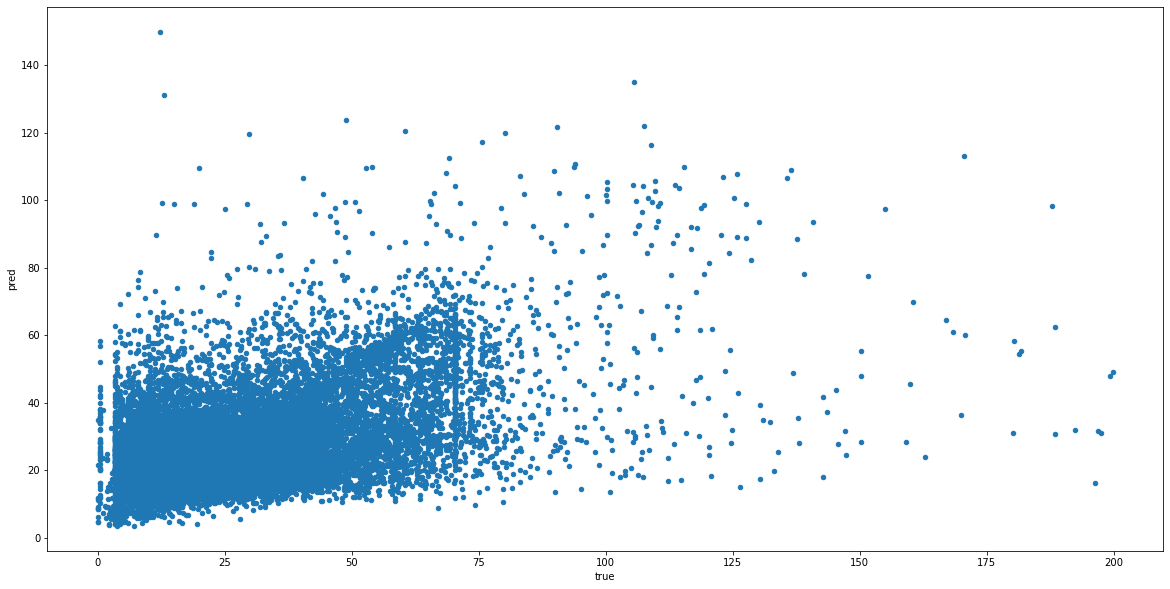

In [763]:
data = {'true': y_test, 'pred': y_pred}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')

## 7.3. Gradient boosting <a id='gradient_boosting'></a>

In [764]:
from sklearn.ensemble import GradientBoostingRegressor

gradBooster = GradientBoostingRegressor()
gradBooster.fit(X_train, y_train)

GradientBoostingRegressor()

In [769]:
model_at_hand = gradBooster

y_pred = model_at_hand.predict(X_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test, y_pred))
print('mean_squared_error', mean_squared_error(y_test, y_pred))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test, y_pred)))
print('r2', r2_score(y_test, y_pred))

mean_absolute_error 8.388198031970221
mean_squared_error 178.98089797962558
root_mean_squared_error 13.378374265194765
r2 0.369081139332866


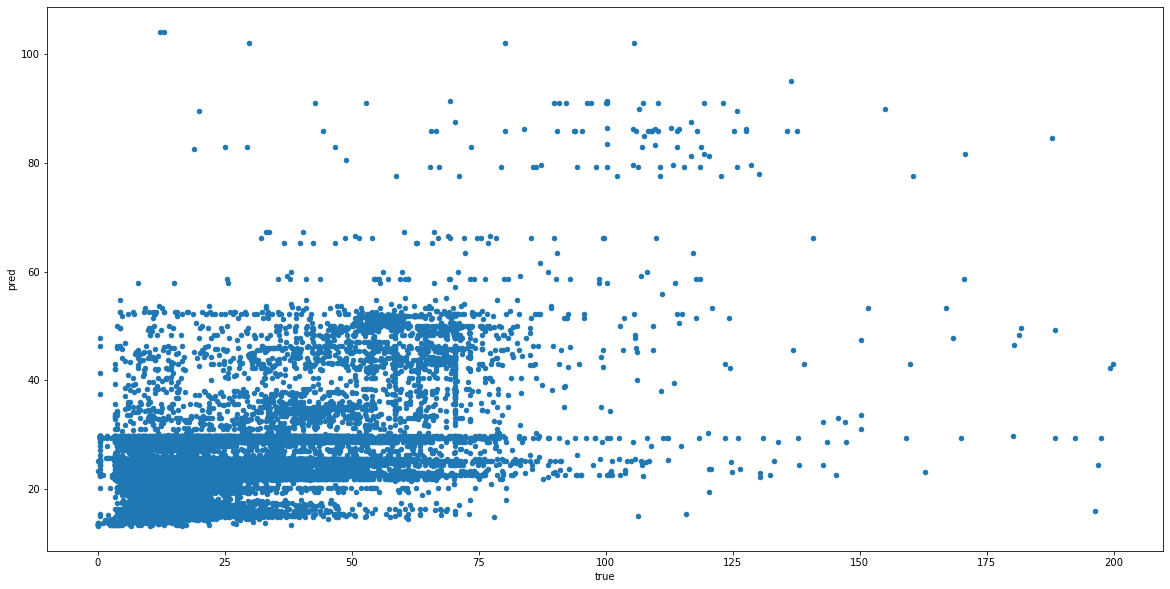

In [770]:
data = {'true': y_test, 'pred': y_pred}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')

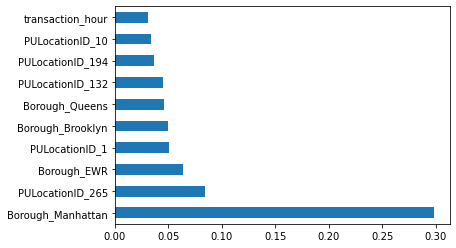

In [771]:
(pd.Series(model_at_hand.feature_importances_, index=X_train.columns)
   .nlargest(10)
   .plot(kind='barh')) 

## 7.4. Comparing algorithm performances <a id='comparing_algorithm_performances'></a>

| Algorithm         |  MAE  |  RMSE  |   R2   |
|-------------------|:-----:|:------:|:------:|
| Benchmark model   | 9.778 | 14.739 |  0.225 |
| Decision tree     | 8.534 | 14.011 |  0.308 |
| Random forest     | 7.426 | 13.212 |  0.385 |
| Gradient boosting | 8.388 | 13.378 |  0.369 |

# 8. Tuning <a id='tuning'></a>
[Back to top](#table_of_contents)

## 8.1. Find best parameters <a id='find_best_parameters'></a>

In [786]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10,20,50,100,150,200,300,500]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 40]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 10, 20]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [787]:
import pprint as pp

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pp.pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 50, 100, 150, 200, 300, 500, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 10, 20],
 'min_samples_split': [2, 5, 10, 20, 40],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [578]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

performances = pd.DataFrame.from_dict(rf_random.cv_results_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 101.8min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 50, 100, 150, 200,
                                                      300, 500, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 10, 20],
                                        'min_samples_split': [2, 5, 10, 20, 40],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [785]:
performances

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0,609.893916,4.279594,18.166433,0.101646,1000,10,1,sqrt,NaN,False,"{'n_estimators': 1000, 'min_samples_split': 10...",0.399992,0.413200,0.409462,0.407551,0.005559,4
1,1,85.114540,0.811083,3.300850,0.020019,200,10,2,sqrt,150.0,True,"{'n_estimators': 200, 'min_samples_split': 10,...",0.418440,0.434528,0.432045,0.428338,0.007072,2
2,2,2771.463416,71.988446,16.597484,0.328360,1000,2,2,auto,500.0,True,"{'n_estimators': 1000, 'min_samples_split': 2,...",0.384569,0.395069,0.395788,0.391809,0.005128,6
3,3,551.652165,19.545405,3.278244,0.028908,200,10,2,auto,300.0,True,"{'n_estimators': 200, 'min_samples_split': 10,...",0.396363,0.409517,0.409461,0.405114,0.006187,5
4,4,5330.319429,171.608584,47.241538,2.772501,1200,5,1,auto,300.0,True,"{'n_estimators': 1200, 'min_samples_split': 5,...",0.383322,0.391188,0.392000,0.388837,0.003913,7
5,5,3465.087614,1394.702060,15.411494,5.578977,600,2,2,auto,NaN,False,"{'n_estimators': 600, 'min_samples_split': 2, ...",0.048022,0.062129,0.058198,0.056116,0.005944,9
6,6,5711.335633,313.651271,15.013489,6.031182,1800,5,1,auto,10.0,False,"{'n_estimators': 1800, 'min_samples_split': 5,...",0.280892,0.277409,0.292584,0.283628,0.006490,8
7,7,18430.497320,1097.873528,169.645481,62.412614,2000,2,1,auto,100.0,False,"{'n_estimators': 2000, 'min_samples_split': 2,...",-0.048452,-0.046208,-0.032492,-0.042384,0.007055,10
8,8,1097.998029,192.646829,43.957627,18.396754,1400,5,1,sqrt,50.0,True,"{'n_estimators': 1400, 'min_samples_split': 5,...",0.409362,0.425126,0.422038,0.418842,0.006821,3
9,9,1866.890890,25.108106,69.483727,9.492094,1800,2,4,sqrt,300.0,True,"{'n_estimators': 1800, 'min_samples_split': 2,...",0.419014,0.435525,0.431126,0.428555,0.006981,1


In [781]:
import time
t0= time.time()

best = RandomForestRegressor(n_estimators=1800,min_samples_split= 2,
min_samples_leaf= 4,
max_features= 'sqrt',
max_depth= 300,
bootstrap= True)
best.fit(X_train, y_train)

t1 = time.time() - t0
print("Time elapsed: ", t1, " seconds")


model_at_hand = best

y_pred = model_at_hand.predict(X_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test, y_pred))
print('mean_squared_error', mean_squared_error(y_test, y_pred))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test, y_pred)))
print('r2', r2_score(y_test, y_pred))

Time elapsed:  320.1432499885559  seconds
mean_absolute_error 7.415934165138361
mean_squared_error 161.17157508125337
root_mean_squared_error 12.695336745484672
r2 0.4318601165261371


In [784]:
from sklearn.ensemble import RandomForestRegressor

import time
t0= time.time()

second_best = RandomForestRegressor(n_estimators=200,min_samples_split= 10,
min_samples_leaf= 2,
max_features= 'sqrt',
max_depth= 150,
bootstrap= True)
second_best.fit(X_train, y_train)

t1 = time.time() - t0
print("Time elapsed: ", t1, " seconds")


model_at_hand = second_best

y_pred = model_at_hand.predict(X_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test, y_pred))
print('mean_squared_error', mean_squared_error(y_test, y_pred))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test, y_pred)))
print('r2', r2_score(y_test, y_pred))

Time elapsed:  40.960970878601074  seconds
mean_absolute_error 7.337100268743273
mean_squared_error 160.32113137873418
root_mean_squared_error 12.661798110013214
r2 0.4348579837729314


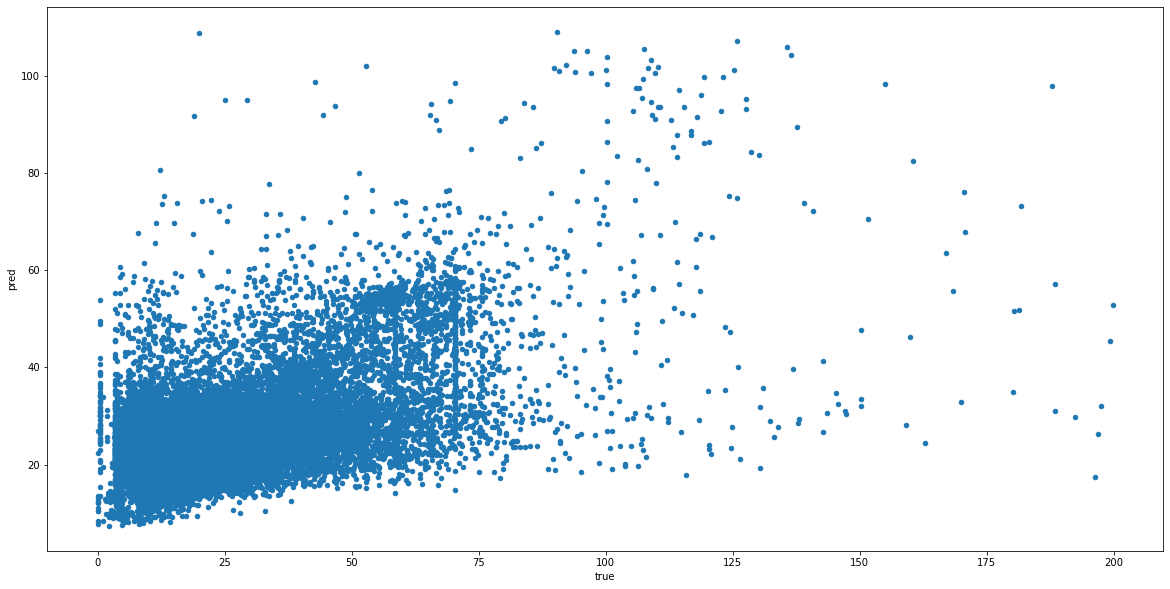

In [788]:
data = {'true': y_test, 'pred': y_pred}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')

## Bonus: Classification <a id='classification'></a>
[Back to top](#table_of_contents)

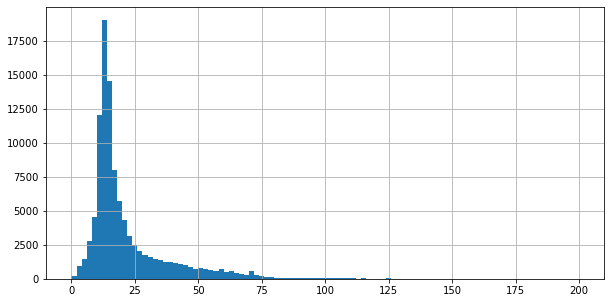

In [791]:
nyc_taxi_with_weather['total_amount'].hist(bins=100, figsize=(10,5))

In [792]:
nyc_class = nyc_taxi_with_weather.copy()
nyc_class['earning_class'] = nyc_taxi_with_weather['total_amount'].apply(lambda x: 'low' if x<=15 else 'high')
nyc_class['earning_class_binary'] = nyc_class['earning_class'].apply(lambda x: 0 if x=='low' else 1)
nyc_class.head()


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,Borough,temperature,humidity,wind speed,cloud cover,amount of precipitation,earning_class,earning_class_binary
0,10,2019-01-01,1,1,0,3.020000,14.300000,2,1,False,True,Queens,8.3,97.0,0.0,1.0,29.0,low,0
1,100,2019-01-01,1,1,0,2.801852,18.130000,54,1,False,True,Manhattan,8.3,97.0,0.0,1.0,29.0,high,1
2,106,2019-01-01,1,1,0,2.593333,15.373333,3,1,False,True,Brooklyn,8.3,97.0,0.0,1.0,29.0,high,1
3,107,2019-01-01,1,1,0,2.437458,14.897458,421,1,False,True,Manhattan,8.3,97.0,0.0,1.0,29.0,low,0
4,11,2019-01-01,1,1,0,1.795000,9.300000,2,1,False,True,Brooklyn,8.3,97.0,0.0,1.0,29.0,low,0


In [793]:
nyc_class['earning_class'].value_counts()

high    53099
low     49457
Name: earning_class, dtype: int64

In [794]:
categorical_features = ['PULocationID', 'transaction_month', 'transaction_day',
       'transaction_hour', 'transaction_week_day', 'weekend', 'is_holiday', 'Borough']
input_features = categorical_features + ['temperature', 'humidity', 'wind speed', 'cloud cover',
       'amount of precipitation']
target_feature = 'earning_class_binary'

In [795]:
from sklearn.model_selection import train_test_split

X_c = nyc_class[input_features]
y_c = nyc_class[target_feature]

# one-hot encode
X_c = pd.get_dummies(X_c)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.33, random_state=42)

In [796]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train_c, y_train_c)

y_pred_c = clf.predict(X_test_c)

In [797]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from math import sqrt

print(confusion_matrix(y_test_c, y_pred_c))

print('accuracy', accuracy_score(y_test_c, y_pred_c))
print('precision', precision_score(y_test_c, y_pred_c))
print('recall', recall_score(y_test_c, y_pred_c))

[[11367  5013]
 [ 3674 13790]]
accuracy 0.74332230232833
precision 0.733393607403074
recall 0.7896243701328447


In [ ]:
(pd.Series(clf.feature_importances_, index=X_train.columns)
   .nlargest(10)
   .plot(kind='barh')) 